# Using custom Dataset to build multiclass image classification model

In [ ]:
# Import torch
import torch
from torch import nn  # nn has all of PyTorch's building blocks for neural networks

# import torchvision related
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor #Converts PIL image or numpy ndarray to tensor
from torch.utils.data import DataLoader

# Import oher key libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from IPython.display import Markdown as md
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu121
0.19.0+cu121


**FYI TorchVision, TorchText, TorchAudio are all PyTorch libraries that provide tools for handling specific types of data used in deep learning**

We are going to explore TorchVision library - Food image classification model

# 1.Get dataset

1. There is a big dataset, Food101, with 101 classes which has 101,000 images.  Source -  https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101
Also site to download this from  - https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

2. Daniel Bourke has created a NB to extrct 3 classes and smaller number of images - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb

3. We are using a subset of Food101 - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip

This is used as the initial iteration with quick loop time

In [ ]:
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip

In [ ]:
import requests
import zipfile
from pathlib import Path

# Set up path to data folder
data_path = Path("data")
img_path = data_path/"pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if img_path.is_dir():
    print(f"{img_path} directory exists.")
else:
    print(f"Did not find {img_path} directory, creating one...")
    img_path.mkdir(parents=True, exist_ok=True)

# Download the dataset
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request =  requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip the zip file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data ...")
  zip_ref.extractall(img_path)

# Remove zip file
import os
os.remove(data_path/"pizza_steak_sushi.zip")
print("Removed the file pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak and sushi data ...
Removed the file pizza_steak_sushi.zip


# 2.Data preparation and Exploration

## 2.1 set train and test path

In [ ]:
f"{img_path}+/train"

'data/pizza_steak_sushi+/train'

In [ ]:
# train_path = '/content/data/pizza_steak_sushi/train'
# test_path = '/content/data/pizza_steak_sushi/test'
train_path = img_path/"train"
test_path = img_path/"test"
train_path, test_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.2 visualize one image from each class

Steps we are going to follow
1. Get all image paths
2. pick a random path and open an image

In [ ]:
# Get all image paths

import random
from PIL import Image
import glob

data_classes = ['sushi', 'steak', 'pizza']

train_path_images = list(train_path.glob("*/*.jpg"))
test_path_images = list(test_path.glob("*/*.jpg"))

# Print length of each of these lists
print(f"Train images: {len(train_path_images)} \nTest images {len(test_path_images)}")


Train images: 225 
Test images 75


Image path:, data/pizza_steak_sushi/train/pizza/3441394.jpg
Image class: pizza
Image height: 512
Image width: 512


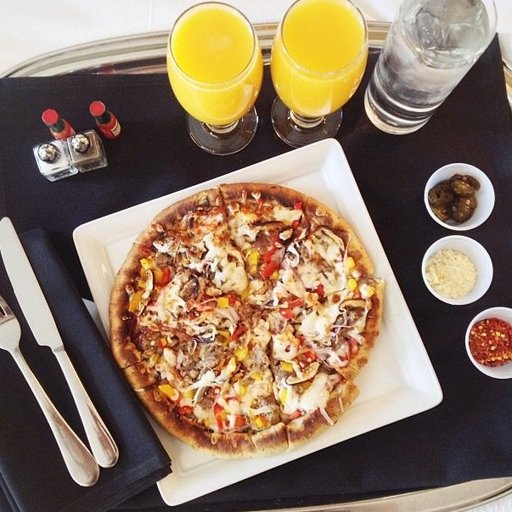

In [ ]:
# Pick a random path and open an image
random_image_path = random.choice(train_path_images)
img_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Image path:, {random_image_path}")
print(f"Image class: {img_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

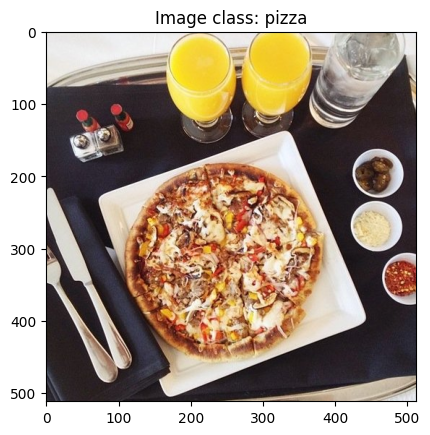

In [ ]:
# Display the image with matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(random_image_path)
imgplot = plt.imshow(img)
plt.title(f"Image class: {img_class}")
plt.show()

In [ ]:
if "/steak/" in "/content/data/pizza_steak_sushi/train/pizza/618348.jpg":
  print(True)

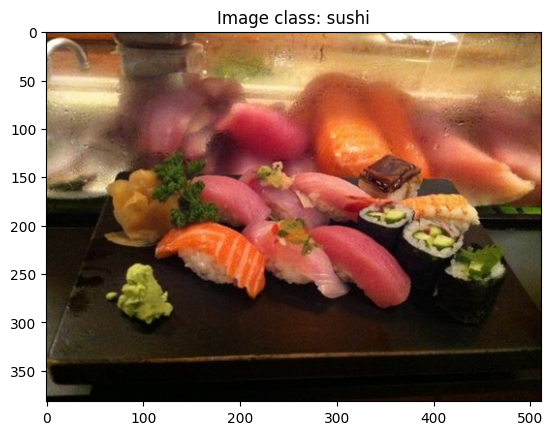

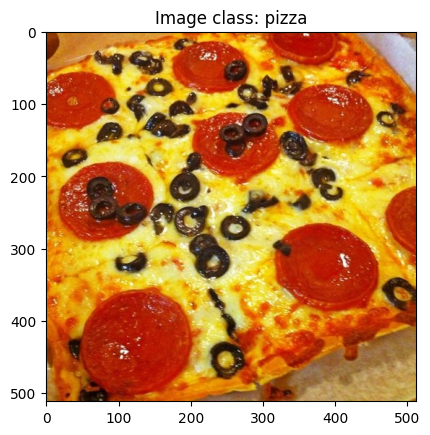

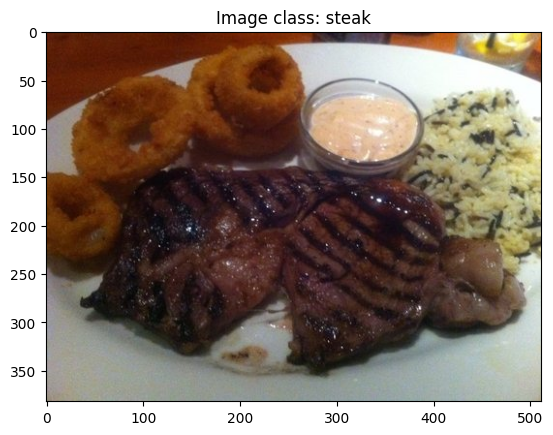

In [ ]:
# One image from each class
train_sushi_images = []
train_pizza_images = []
train_steak_images = []

for img_p in train_path_images:
  img_c = img_p.parent.stem
  if 'sushi' == img_c:
    train_sushi_images.append(img_p)
  elif 'pizza' == img_c:
    train_pizza_images.append(img_p)
  elif 'steak' == img_c:
    train_steak_images.append(img_p)

random_sushi_image = random.choice(train_sushi_images)
random_pizza_image = random.choice(train_pizza_images)
random_steak_image = random.choice(train_steak_images)


img = mpimg.imread(random_sushi_image)
imgplot = plt.imshow(img)
plt.title(f"Image class: {random_sushi_image.parent.stem}")
plt.show()

img = mpimg.imread(random_pizza_image)
imgplot = plt.imshow(img)
plt.title(f"Image class: {random_pizza_image.parent.stem}")
plt.show()

img = mpimg.imread(random_steak_image)
imgplot = plt.imshow(img)
plt.title(f"Image class: {random_steak_image.parent.stem}")
plt.show()

## 2.3 Transform data into tensors

1. Turn to numerical representation -  tensors
2. Turn it into `torch.utils.Data.Dataset` and then into
`torch.utils.Data.DataLoader`

Transforms help you turn images to pytorch tensors - https://pytorch.org/vision/stable/transforms.html

In [ ]:
# Get one image
random_image_path = random.choice(train_path_images)
img_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Image path:, {random_image_path}")
print(f"Image class: {img_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

Image path:, data/pizza_steak_sushi/train/pizza/3821701.jpg
Image class: pizza
Image height: 288
Image width: 512


In [ ]:
# Transform the randomly selected image to tensor
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize(size = (64,64)), # Resize the image to 64 x 64 shape
    transforms.RandomHorizontalFlip(p=0.5), # Flip image horizontally with probability = 50%
    transforms.ToTensor()
    ])

# Convert the image to Torch tensor
t1 = transform(img)
t1.shape, t1.dtype

(torch.Size([3, 64, 64]), torch.float32)

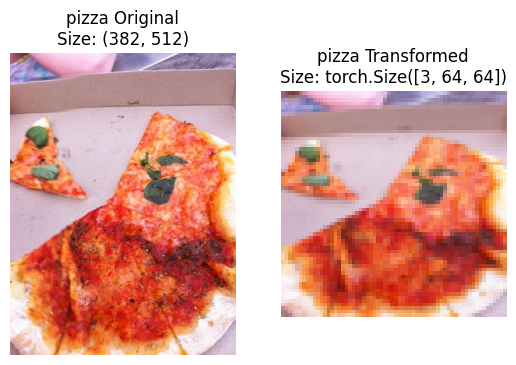

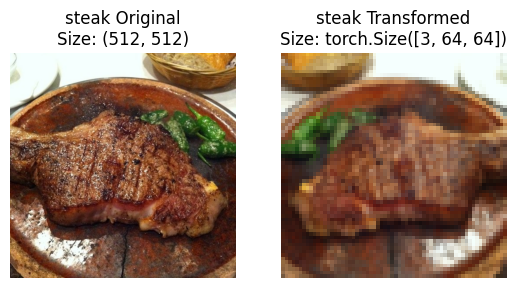

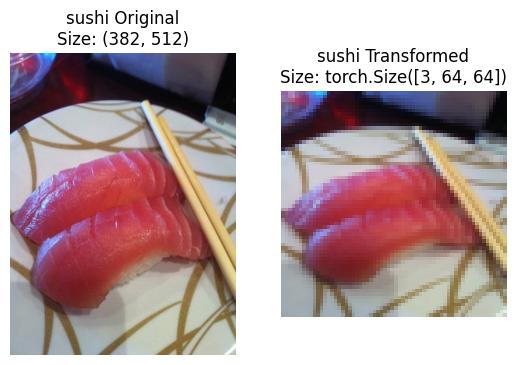

In [ ]:
# Compare some of the original images vs transformed images

images = random.sample(train_path_images,3)

for img in images:
  img_class = img.parent.stem
  with Image.open(img) as f:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(f)
    ax[0].set_title(f"{img_class} Original\nSize: {f.size}")
    ax[0].axis(False)

    t1 = transform(f)
    ax[1].imshow(t1.permute(1,2,0))
    ax[1].set_title(f"{img_class} Transformed\nSize: {t1.size()}")
    ax[1].axis(False)
    plt.show()

# 3.Load all image data to tensor using `torchvision.datasets.ImageFolder`

In [ ]:
# Use imagefolder to create datafolder

from torchvision import datasets
train_data = datasets.ImageFolder(train_path, transform = transform)
test_data = datasets.ImageFolder(test_path, transform = transform)

In [ ]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Check classes in train and test data
train_data.classes, test_data.classes, train_data.class_to_idx, test_data.class_to_idx

(['pizza', 'steak', 'sushi'],
 ['pizza', 'steak', 'sushi'],
 {'pizza': 0, 'steak': 1, 'sushi': 2},
 {'pizza': 0, 'steak': 1, 'sushi': 2})

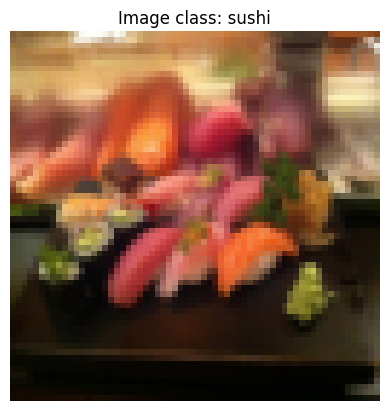

In [ ]:
# Check a random image from train
inverse_class_dict = {v: k for k, v in train_data.class_to_idx.items()}
random_train_img = random.randint(0,len(train_data))

img, label_idx = train_data[random_train_img]

# train_data.class_to_idx[train_data[random_train_img][1]]
plt.imshow(img.permute(1,2,0).squeeze())
plt.title(f"Image class: {inverse_class_dict[label_idx]}")
plt.axis(False)
plt.show()

## Turn it into torch.utils.Data.Dataset and then into torch.utils.Data.DataLoader

In [ ]:
BATCH_SIZE = 32

train_data_batches = DataLoader(train_data,
                                batch_size = BATCH_SIZE,
                                shuffle = True)

test_data_batches = DataLoader(test_data,
                                batch_size = BATCH_SIZE,
                                shuffle = False)

In [ ]:
len(train_data), len(test_data), len(train_data_batches), len(test_data_batches)

(225, 75, 8, 3)

In [ ]:
train_features, train_labels = next(iter(train_data_batches))
train_features.shape, train_labels.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

Feature batch shape: torch.Size([32, 3, 64, 64])
Labels batch shape: torch.Size([32])


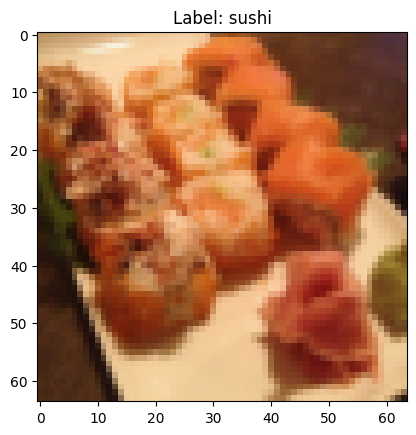

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_data_batches))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.title(f"Label: {inverse_class_dict[label.item()]}")
plt.show()


## Other forms of data Transformation --
Augmentation

Adding different variations to get veriety of dataset based on images we already have

There are many forms of data augmentation
- Rotation
- Crop
- Zoom
- Tilt
- Color changes/ brightness/contrast

Explore more here - https://pytorch.org/vision/stable/transforms.html

Excellent Blogpost - https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

# 4.Build & train Convolutional Neural Network(CNN) Model


In [ ]:
# Setting up model evaluation method
torch.manual_seed(0)
# Model_fashion_0.eval()

# Define a evaluation metrics -- Accuracy for simplicity
def accuracy_fn(y_true, y_pred):
  correct_preds = torch.eq(y_true,y_pred).sum().item()
  acc = correct_preds/len(y_pred)
  return acc

def eval_model(model:nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
  """ Returns a dictionary containing the results of model predicting on data loader"""
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for x,y in tqdm(data_loader):
      logits = model(x).squeeze()
      y_pred_prob = torch.softmax(logits, dim=1)
      y_pred = y_pred_prob.argmax(dim=1)
      loss += loss_fn(logits, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred)
  results = {"model_name": model.__class__.__name__,
             "model_loss": loss.item()/len(data_loader),
             "model_acc": acc/len(data_loader)}
  return results

In [ ]:
# Create a convolutional Neural network(CNN) Model
class tinyvgg_cnn_model(nn.Module):
  """
  Model architecture that replicates TinyVGG model from CNN explainer website
  """
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int): # We can get parameters at the beginning so that we can call them with model subclass call
    super().__init__()
    """ There are multiple layers and some of these layers are clubbed together to be called as blocks.
    when we combine these blocks we get the entire CNN Model -- just like lego blocks """
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units,
                  kernel_size = 3, stride = 1, padding =0), # Conv2d as we have a 2d data. These are the hyperparams which we need to define
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, stride = 1, padding =0), # Conv2d as we have a 2d data. These are the hyperparams which we need to define
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, stride = 1, padding =0), # Conv2d as we have a 2d data. These are the hyperparams which we need to define
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                  kernel_size = 3, stride = 1, padding =0), # Conv2d as we have a 2d data. These are the hyperparams which we need to define
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier_block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units* 13 * 13 , out_features=output_shape) # trick to get the input shape here is to printout each layers output, which will tell you what shape should the input to maxpool should be!
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier_block(x)
    # print(x.shape)
    return x

In [ ]:
# Instantiate First CNN model
torch.manual_seed(0)
Model_3 = tinyvgg_cnn_model(input_shape = 3, # number of color channels in the training image
                                         hidden_units = 10,
                                         output_shape = len(train_data.classes))

In [ ]:
Model_3

tinyvgg_cnn_model(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

***Another way to get more info of the model we have built***

In [ ]:
# Install/import torchinfo
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(Model_3, input_size = (1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
tinyvgg_cnn_model                        [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [ ]:
# Define loss func and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = Model_3.parameters(),lr = 0.001) # very high LR

In [ ]:
Model_3.eval()
with torch.inference_mode():
  for test_img, test_label in test_data_batches:
    # 1. forward pass
    test_logits = Model_3(test_img).squeeze()
    test_pred_prob = torch.softmax(test_logits, dim=1)
    test_pred = test_pred_prob.argmax(dim=1)

In [ ]:
test_pred

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
eval_model(Model_3, test_data_batches, loss_fn , accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

{'model_name': 'tinyvgg_cnn_model',
 'model_loss': 1.0917507807413738,
 'model_acc': 0.5416666666666666}

In [ ]:
# Training loop

torch.manual_seed(0)

epochs = 5

Model_3.train()
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = 0, 0
  for batch, (train_img, train_label) in enumerate(train_data_batches):

    # 1. forward pass
    train_logits = Model_3(train_img)
    train_pred_prob = torch.softmax(train_logits, dim=1)
    train_pred = train_pred_prob.argmax(dim=1)

    # 2. calculate_loss
    # print(train_logits.shape, train_label.shape)
    loss = loss_fn(train_logits, train_label)
    train_loss += loss
    train_acc += accuracy_fn(y_true = train_label, y_pred = train_pred)

    # 3. compute grad and backpropagate
    optimizer.zero_grad()
    loss.backward()

    # 4. Take a step with the optimizer
    optimizer.step()
  print(f"Avg train_loss after {epoch}: {loss.item()/len(train_data_batches):.4f}| Avg train_accuracy {train_acc/len(train_data_batches):.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Avg train_loss after 0: 0.1356| Avg train_accuracy 0.3867
Avg train_loss after 1: 0.1505| Avg train_accuracy 0.2930
Avg train_loss after 2: 0.1439| Avg train_accuracy 0.2930
Avg train_loss after 3: 0.1365| Avg train_accuracy 0.4141
Avg train_loss after 4: 0.1336| Avg train_accuracy 0.4141


In [ ]:
eval_model(Model_3, test_data_batches, loss_fn , accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

{'model_name': 'tinyvgg_cnn_model',
 'model_loss': 1.1099969546000164,
 'model_acc': 0.19791666666666666}

# 5.Trying Data Augmentation and running for longer to improve performance

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

In [ ]:
# Create a transform
from torchvision import transforms
train_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=500),
                                      transforms.ToTensor()
])

In [ ]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(train_path, transform = train_transform)

In [ ]:
len(train_data_augmented)

225

In [ ]:
BATCH_SIZE = 32

train_data_batches_augmented = DataLoader(train_data_augmented,
                                batch_size = BATCH_SIZE,
                                shuffle = True)

In [ ]:
len(train_data_batches_augmented)

8

In [ ]:
# Instantiate First CNN model
torch.manual_seed(42)
Model_4 = tinyvgg_cnn_model(input_shape = 3, # number of color channels in the training image
                                         hidden_units = 10,
                                         output_shape = len(train_data.classes))

# Define loss func and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = Model_4.parameters(),lr = 0.001) # very high LR


# Training loop

torch.manual_seed(42)

epochs = 25

Model_4.train()
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = 0, 0
  for batch, (train_img, train_label) in enumerate(train_data_batches):

    # 1. forward pass
    train_logits = Model_4(train_img)
    train_pred_prob = torch.softmax(train_logits, dim=1)
    train_pred = train_pred_prob.argmax(dim=1)

    # 2. calculate_loss
    # print(train_logits.shape, train_label.shape)
    loss = loss_fn(train_logits, train_label)
    train_loss += loss
    train_acc += accuracy_fn(y_true = train_label, y_pred = train_pred)

    # 3. compute grad and backpropagate
    optimizer.zero_grad()
    loss.backward()

    # 4. Take a step with the optimizer
    optimizer.step()
  print(f"Avg train_loss after {epoch}: {loss.item()/len(train_data_batches):.4f}| Avg train_accuracy {train_acc/len(train_data_batches):.4f}")


  0%|          | 0/25 [00:00<?, ?it/s]

Avg train_loss after 0: 0.1377| Avg train_accuracy 0.2500
Avg train_loss after 1: 0.1166| Avg train_accuracy 0.4258
Avg train_loss after 2: 0.1598| Avg train_accuracy 0.3047
Avg train_loss after 3: 0.1425| Avg train_accuracy 0.3047
Avg train_loss after 4: 0.1454| Avg train_accuracy 0.3320
Avg train_loss after 5: 0.1460| Avg train_accuracy 0.3203
Avg train_loss after 6: 0.1141| Avg train_accuracy 0.5469
Avg train_loss after 7: 0.1208| Avg train_accuracy 0.6055
Avg train_loss after 8: 0.0848| Avg train_accuracy 0.5859
Avg train_loss after 9: 0.1449| Avg train_accuracy 0.4648
Avg train_loss after 10: 0.0823| Avg train_accuracy 0.5938
Avg train_loss after 11: 0.0878| Avg train_accuracy 0.6289
Avg train_loss after 12: 0.1753| Avg train_accuracy 0.4805
Avg train_loss after 13: 0.2081| Avg train_accuracy 0.5312
Avg train_loss after 14: 0.1096| Avg train_accuracy 0.5234
Avg train_loss after 15: 0.0865| Avg train_accuracy 0.6016
Avg train_loss after 16: 0.0989| Avg train_accuracy 0.4492
Avg tra

In [ ]:
eval_model(Model_4, test_data_batches, loss_fn , accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

{'model_name': 'tinyvgg_cnn_model',
 'model_loss': 0.9496803283691406,
 'model_acc': 0.4933712121212121}

# 6.Testing on a custom Image

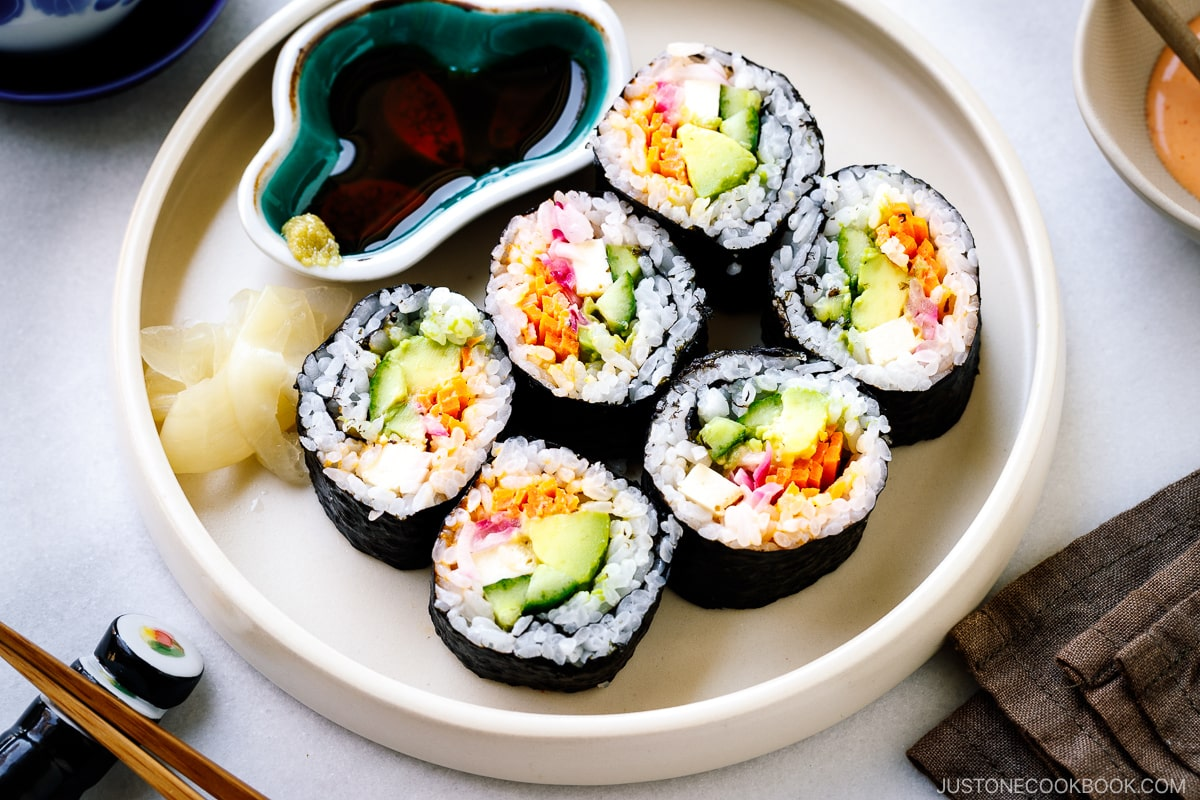

In [ ]:
# The original file location is here
# https://www.google.com/imgres?q=image%20of%20pizza%20jpg&imgurl=https%3A%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fcommons%2Fthumb%2F8%2F86%2FPizza_%25281%2529.jpg%2F1200px-Pizza_%25281%2529.jpg&imgrefurl=https%3A%2F%2Fcommons.wikimedia.org%2Fwiki%2FFile%3APizza_(1).jpg&docid=zDGob4bkAinhkM&tbnid=RATCdXJGHCvpHM&vet=12ahUKEwjWxbjxnsuIAxXNKlkFHVLyHikQM3oECBYQAA..i&w=1200&h=804&hcb=2&ved=2ahUKEwjWxbjxnsuIAxXNKlkFHVLyHikQM3oECBYQAA

cust_test_image_path = '/Test_img_4.jpg'

# /Test_img_2.jpg
img = Image.open(cust_test_image_path)
img

In [ ]:
# Transform the randomly selected image to tensor
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize(size = (64,64)), # Resize the image to 64 x 64 shape
    transforms.RandomHorizontalFlip(p=0.5), # Flip image horizontally with probability = 50%
    transforms.ToTensor()
    ])

# Convert the image to Torch tensor
t1 = transform(img)
t1.shape, t1.dtype

(torch.Size([3, 64, 64]), torch.float32)

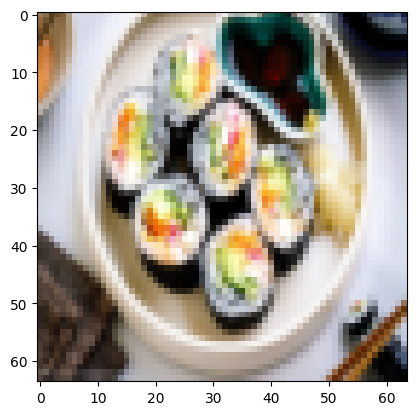

In [ ]:
plt.imshow(t1.permute(1,2,0))

In [ ]:
t2 = t1.unsqueeze(0)
Model_4.eval()
with torch.inference_mode():
  test_logits = Model_4(t2)
  test_pred_prob = torch.softmax(test_logits, dim=1)
  test_pred = test_pred_prob.argmax(dim=1)

inverse_class_dict = {v: k for k, v in train_data.class_to_idx.items()}
inverse_class_dict[test_pred.item()], test_pred_prob.squeeze()[test_pred.item()]

('sushi', tensor(0.5554))

**It could predict right! Honestly it isn't a great model. But definitely a good start :)**

There are many ways to improve the model
- Starting with getting more number of samples (data to train)
- Increase the dimensions from 64*64 to may be 224
- chnage the architecture -- increase layers/conv/neurons
- Chane optimizer, learning rate and loss function